In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from tqdm import tqdm, trange
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
from shapely import affinity
from shapely.geometry import Polygon

In [2]:
def get_processed_tensors(data, normalize=True):
    # add direction attributes
    vehicle_mean_speed = data.groupby(['ego_id','recording_id']).ego_xVel.transform('mean')
    vehicle_abs_speed = vehicle_mean_speed.abs() 
    data['dir'] = vehicle_mean_speed / vehicle_abs_speed
    # add lane changing attributes
    ego_pre_lc = data.groupby(['ego_id','recording_id']).ego_pre_lc.transform('any')
    ego_post_lc = data.groupby(['ego_id','recording_id']).ego_post_lc.transform('any')
    ego_lc = ego_pre_lc | ego_post_lc
    foe_pre_lc = data.groupby(['foe_id','recording_id']).foe_pre_lc.transform('any')
    foe_post_lc = data.groupby(['foe_id','recording_id']).foe_post_lc.transform('any')
    foe_lc = foe_pre_lc | foe_post_lc
    data['ego_lc'] = ego_lc
    data['foe_lc'] = foe_lc
    ego_xVel = np.abs(data.ego_xVel.values)
    ego_yVel = np.abs(data.ego_yVel.values) * data.dir.values
    rel_xVel = -((data.ego_xVel - data.foe_xVel)*(data.ego_x - data.foe_x) / abs(data.ego_x - data.foe_x)).values
    rel_yVel = -((data.ego_yVel - data.foe_yVel)*(data.ego_y - data.foe_y) / abs(data.ego_y - data.foe_y)).values
    ego_lc = data.ego_lc
    foe_lc = data.foe_lc
    ego_class = data.ego_truck.values
    foe_class = data.foe_truck.values
    X = np.clip( abs(data.ego_x - data.foe_x) -  0.5*(data.ego_length + data.foe_length), a_min=0, a_max=None).values *((data.foe_x - data.ego_x) / abs(data.ego_x - data.foe_x)).values * data.dir.values
    Y = np.clip( abs(data.ego_y - data.foe_y) -  0.5*(data.ego_width + data.foe_width), a_min=0, a_max=None).values *((data.foe_y - data.ego_y) / abs(data.ego_y - data.foe_y)).values * data.dir.values
    np.nan_to_num(X, 0)
    np.nan_to_num(Y, 0)
    X = torch.Tensor(X).to('cuda').detach()
    Y = torch.Tensor(Y).to('cuda').detach()
    Input = np.array(
    [
        ego_xVel, ego_yVel, rel_xVel, rel_yVel, ego_lc, foe_lc, ego_class, foe_class
    ]
    ).T
    np.nan_to_num(Input, 0)
    Input = torch.Tensor(Input).to('cuda')
    if normalize:
        Input[:,0] = Input[:,0] / torch.quantile(Input[:,0], 0.95)
        Input[:,1] = Input[:,1] / 1
        Input[:,2] = Input[:,2] / 15
        Input[:,3] = Input[:,3] / 1.25
    dataset = torch.cat([Input, X.view(-1,1)], dim=1)
    dataset = torch.cat([dataset, Y.view(-1,1)], dim=1)
    _x = torch.Tensor( (data.foe_x - data.ego_x).values ).to('cuda')
    _y = torch.Tensor( (data.foe_y - data.ego_y).values ).to('cuda')
    dataset = torch.cat([dataset, _x.view(-1,1)], dim=1)
    dataset = torch.cat([dataset, _y.view(-1,1)], dim=1)
    return dataset

In [3]:
data_path = "D:/Productivity/Projects/RiskFieldImitation-main/data"
print (f"---- Reading raw data ----")
full_data = pd.concat([ pd.read_csv(f"{data_path}/{r:02}_spacings_2.csv",index_col=0) for r in trange(1,61)])
print (f"---- Generating tensor ----")
full_data = get_processed_tensors(full_data)

---- Reading raw data ----


100%|██████████| 60/60 [00:06<00:00,  9.74it/s]


---- Generating tensor ----


In [42]:
def find_neighbors_batch(data, query_point, epsilon=0.2, search_dims=[0,1,2,3,4,6,], batch_size=10000, k=0):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    num_samples = data.shape[0]
    indices_list = [] 
    for i in range(0, num_samples, batch_size):
        bound = i + batch_size if i+batch_size < num_samples else num_samples
        batch = data[i:bound] 
        distances = torch.norm(batch[:,search_dims] - query_point[search_dims], dim=1)
        mask = distances <= epsilon
        found_indices = torch.nonzero(mask, as_tuple=True)[0] + i
        indices_list.append(found_indices.to('cuda'))
    indices = torch.cat(indices_list) if indices_list else torch.tensor([]).to('cuda')
    return indices

In [43]:
def loss_x(gx, gy, x, y, beta_x, beta_y):
    gx_expanded = gx[:, None]
    _exp = - (torch.abs(x / gx_expanded) ** beta_x) - (torch.abs(y / gy) ** beta_y)
    l = torch.sum(torch.log(1 - torch.exp(_exp)), dim=1)
    ux = torch.autograd.grad(l, gx,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(l)
                        )[0]
    uux = torch.autograd.grad(ux, gx,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(ux)
                        )[0]
    return gx[torch.argmin(uux)]

def loss_y(gx, gy, x, y, beta_x, beta_y):
    gy_expanded = gy[:, None]
    _exp = - (torch.abs(x / gx) ** beta_x) - (torch.abs(y / gy_expanded) ** beta_y)
    l = torch.sum(torch.log(1 - torch.exp(_exp)), dim=1)
    uy = torch.autograd.grad(l, gy,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(l)
                        )[0]
    uuy = torch.autograd.grad(uy, gy,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(uy)
                        )[0]
    return gy[torch.argmin(uuy)]

def numerical_search_gamma(x, y, max_step=int(1e4), gx_range=np.arange(0.1,100,0.1), gy_range=np.arange(0.1,5,0.1), beta_x=5, beta_y=5, init_gx=2, init_gy=2):
    gx_range=torch.tensor(gx_range, requires_grad=True, device='cuda')
    gy_range=torch.tensor(gy_range, requires_grad=True, device='cuda')
    gx = init_gx
    gy = init_gy
    for it in trange(max_step):
        # 
        prev_gx = gx
        prev_gy = gy
        # update gx
        candidate_gx = loss_x(gx_range, gy, x, y, beta_x, beta_y)
        gx = candidate_gx
        # update gy
        candidate_gy = loss_y(gx, gy_range, x, y, beta_x, beta_y)
        gy = candidate_gy
        if abs(gx-prev_gx)<0.1 and abs(gy-prev_gy)<0.1:
            break
    return gx, gy

In [44]:
def plot_subjective_field(x, y, dim=[4.5, 1.7], gx=2, gy=2, bx=5, by=5, l=4.5, w=1.7):
    def get_vehicle_shape(loc, dim, rad=0, use_radians=True):
        x, y = loc
        L, W = dim
        x1, y1 = [x-L/2, y+W/2]
        x2, y2 = [x+L/2, y+W/2]
        x3, y3 = [x+L/2, y-W/2]
        x4, y4 = [x-L/2, y-W/2]
        vshape = ((x1,y1),(x2,y2),(x3,y3),(x4,y4))
        #print (L,W)
        vPolygon = Polygon(vshape)
        vPolygon = affinity.rotate(vPolygon, rad, origin='center', use_radians=use_radians)
        return vPolygon

    fig = plt.figure(figsize=(4,10))
    ax = fig.add_subplot(111)
    ax.grid()
    
    
    ax.scatter(y.cpu(), x.cpu(), color='black', s=0.1)
    ax.set_xlim(-4.5,4.5)
    ax.set_ylim(-80,80)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

    vp = get_vehicle_shape(loc=[0,0],dim=[w,l])
    xs, ys = vp.exterior.xy
    shape = ax.fill(xs, ys, 'red', alpha=0.95, ec='black')
    dotx = np.arange(-5, 5, 0.2)
    doty = np.arange(-80, 80, 0.2)
    X, Y = np.meshgrid(dotx, doty)
    # get ego state
    Z = np.zeros(X.shape)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            _x = Y[i][j]
            _y = X[i][j]
            __x = (abs(_x) - (l/2 + dim[0]/2))*_x/abs(_x) if abs(_x)>(l/2 + dim[0]/2) else 0
            __y = (abs(_y) - (w/2 + dim[1]/2))*_y/abs(_y) if abs(_y)>(w/2 + dim[1]/2) else 0
            f = torch.exp(- (torch.abs(__x / gx) ** bx) - (torch.abs(__y / gy) ** by))
            Z[i][j] = f

    CS = ax.contour(X, Y, Z, [np.exp(-1)], colors=['red'], linewidths=2.00, linestyles='solid') 
    # plt.show()
    # colormap = np.full(Z.shape, 'none')

In [45]:
def longitudinal_gamma(gx, x, y, beta_x):
    x = x[y==0] 
    _ = 0 if len(x) else print ("No longitudinal samples found")
    gx_expanded = gx[:, None]
    _exp = - (torch.abs(x / gx_expanded) ** beta_x) 
    l = torch.sum(torch.log(1 - torch.exp(_exp)), dim=1)
    ux = torch.autograd.grad(l, gx,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(l)
                        )[0]
    uux = torch.autograd.grad(ux, gx,
                        create_graph=True,
                        allow_unused=True,
                        grad_outputs=torch.ones_like(ux)
                        )[0]
    return gx[torch.argmin(uux)]

In [ ]:
key = torch.where(full_data[:,3]>0.5)[0].cpu().numpy()[672]
query_point = full_data[key]

In [638]:
query_point = torch.tensor([1.2, 0.0, 0.4, 0, 1, 0, 0, 0], device='cuda')

In [639]:
print (f"---- ego speed x: {query_point[0]*36.9500} m/s ----")
print (f"---- ego speed y: {query_point[1]*1} m/s ----")
print (f"---- relative speed x: {query_point[2]*15} m/s ----")
print (f"---- relative speed y: {query_point[3]*1.25} m/s ----")
print (f"---- ego lc: {query_point[4]} ----")
print (f"---- foe lc: {query_point[5]} ----")
print (f"---- ego truck: {query_point[6]} ----")
print (f"---- foe truck: {query_point[7]} ----")

---- ego speed x: 44.340003967285156 m/s ----
---- ego speed y: 0.0 m/s ----
---- relative speed x: 6.0 m/s ----
---- relative speed y: 0.0 m/s ----
---- ego lc: 1.0 ----
---- foe lc: 0.0 ----
---- ego truck: 0.0 ----
---- foe truck: 0.0 ----


In [641]:
indices = find_neighbors_batch(full_data, query_point, epsilon=0.2)
indices = indices if len(indices)<3000 else np.random.choice(indices.cpu().numpy(), 3000)
print (f"Found neighbors: {len(indices)}")

Found neighbors: 1109


In [642]:
ego_dim = [4.7, 1.7]
foe_dim = [4.7, 1.7]

In [643]:
neighbors = full_data[indices]

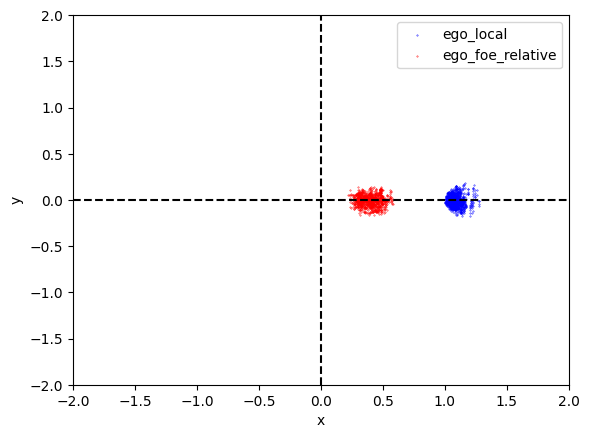

In [644]:
plt.scatter(neighbors[:,0].cpu(), neighbors[:,1].cpu(), color='blue', s=0.1, label='ego_local')
plt.scatter(neighbors[:,2].cpu(), neighbors[:,3].cpu(), color='red', s=0.1, label='ego_foe_relative')
plt.axhline(0, linestyle='dashed', color='black')
plt.axvline(0, linestyle='dashed', color='black')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

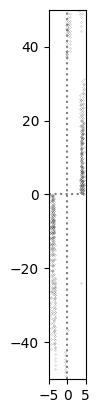

In [645]:
_x = neighbors[:,10] 
_y = neighbors[:,11] 
x = neighbors[:,8] 
y = neighbors[:,9] 
plt.scatter(_y.cpu(), _x.cpu(), color='black', s=0.01)
plt.ylim(-50, 50)
plt.xlim(-5, 5)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [646]:
gx_range = torch.tensor(torch.tensor(np.arange(0.1,100,0.1), requires_grad=True, device='cuda'), requires_grad=True, device='cuda')
gy_range = torch.tensor(torch.tensor(np.arange(0.1,5,0.1), requires_grad=True, device='cuda'), requires_grad=True, device='cuda')
_gx = longitudinal_gamma(gx_range, x, y, 5)
_gx

C:\Users\APT1807\AppData\Local\Temp\ipykernel_52728\1606232854.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gx_range = torch.tensor(torch.tensor(np.arange(0.1,100,0.1), requires_grad=True, device='cuda'), requires_grad=True, device='cuda')
C:\Users\APT1807\AppData\Local\Temp\ipykernel_52728\1606232854.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gy_range = torch.tensor(torch.tensor(np.arange(0.1,5,0.1), requires_grad=True, device='cuda'), requires_grad=True, device='cuda')


tensor(33.3000, device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [647]:
_gy = loss_y(_gx, gy_range, x, y, 5, 5)
_gy

tensor(1.6000, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)

100%|██████████| 800/800 [00:04<00:00, 172.29it/s]


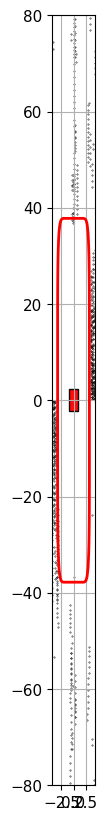

In [648]:
plot_subjective_field(_x, _y, dim=[4.5, 1.7], gx=_gx, gy=_gy, bx=5, by=5, l=4.5, w=1.7)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 4., 4., 2., 0., 2., 0., 0., 3., 2., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 5.,
        6., 5., 8., 6., 4., 5., 4., 5., 5., 3., 2., 2., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-5.00000000e+00, -4.90000000e+00, -4.80000000e+00, -4.70000000e+00,
        -4.60000000e+00, -4.50000000e+00, -4.40000000e+00, -4.30000000e+00,
        -4.20000000e+00, -4.10000000e+00, -4.00000000e+00, -3.90000000e+00,
        -3.80000000e+00, -3.70000000e+00, -3.60000000e+00, -3.50000000e+00,
        -3.40000000e+00, -3.30000000e+00, -3.20000000e+00, -3.10000000e+00,
        -3.00000000e+00, -2.90000000e+00, -2.80000000e+00, -2.70000000e+00,
        -2.60000000e+00, -2.50000000e+00, -2.40000000e+00, -2.30000000e+00,
        -2.20000000e+0

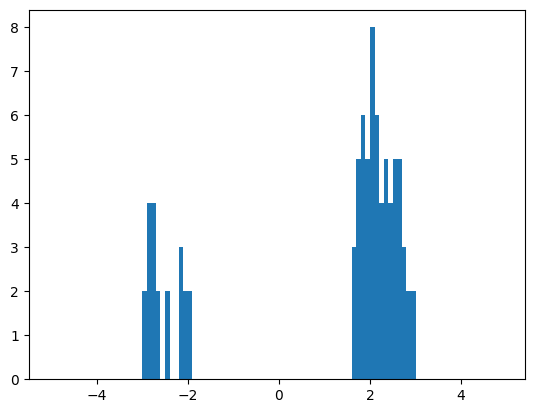

In [73]:
ys = neighbors[abs(neighbors[:,8]==0)][:,9]
plt.hist(ys.cpu(), bins=np.arange(-5,5,0.1))

(array([16., 11., 12., 21., 21., 13.,  8., 13.,  9., 11.,  6.,  7.,  5.,
         9., 11.,  9., 11., 19.,  9., 10., 18., 24., 13., 15., 20., 18.,
        15., 10., 10., 10.,  9., 20., 16., 14., 18., 19., 21., 19., 20.,
        15., 14., 21., 12.,  9.,  9., 21., 12., 20., 26., 26., 18., 31.,
        18., 24., 19., 13., 20., 23., 18., 16., 13., 18., 23., 12.,  3.,
         3.,  1.,  4.,  3.,  3.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         3.,  1.,  0.,  0.,  1.,  6.,  9.,  4.,  5.,  7.,  6.,  3.,  9.,
         5., 11.,  8., 13., 19., 15., 20., 13., 13., 15.,  8., 13.,  8.,
         6.,  8.,  8.,  1., 10.,  7., 19.,  6.,  5.,  2.,  6.,  6.,  9.,
         6.,  5.,  5.,  3.,  8.,  6.,  6.,  3.,  5., 10.,  6.,  9., 10.,
         5.,  9.,  5.,  3.,  0.,  0.,  2.,  5.,  6.,  3.,  3.,  7., 10.,
         9.,  6.,  5.]),
 array([-80., -79., -78., -77., -76., -75., -74., -73., -72., -71., -70.,
        -69., -68., -67.,

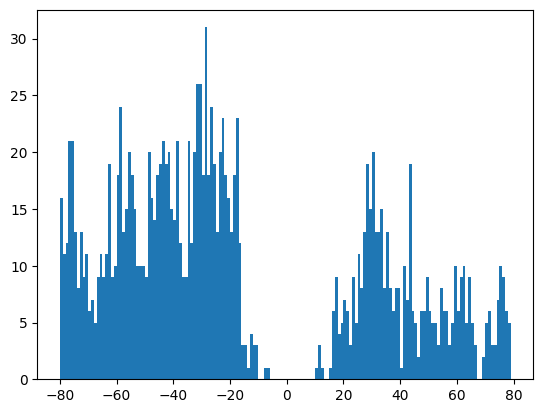

In [74]:
xs = neighbors[(neighbors[:,9]==0)][:,8]
plt.hist(xs.cpu(), bins=np.arange(-80,80,1))

tensor([  19852,   19853,   19854,   19855,   19856,   19857,   34251,   34252,
          34253,   44308,   44309,   50988,   50989,   50990,   50991,   50992,
          50993,   50994,   78918,   78919,   78920,   78921,   78922,  121264,
         121266,  121268,  121270,  121272,  121274,  121306,  121308,  121310,
         121312,  121314,  121316,  121318,  121320,  121322,  121324,  121326,
         121328,  121330,  128666,  128667,  128668,  128669,  224684,  224685,
         263920,  263923,  452587,  452589,  452591,  452593,  469592,  469593,
         469594,  469595, 1077051, 1098893, 1098894, 1098895, 1177389, 1177391,
        1177393, 1177406, 1189312, 1308016, 1308017, 1340025, 1340026, 1340027,
        1356166, 1356167, 1356168, 1356169, 1394602, 1408698, 1408699, 1445697,
        1546445, 1546447, 1546449, 1546451, 1546452, 1546454, 1546455, 1546457,
        1546458, 1546460, 1546461, 1546463, 1546464, 1546467, 1546469, 1546470,
        1546474, 1546476, 1546478, 15464

In [67]:

def remove_similar_data(data, epsilon=0.1):
    """
    Remove similar data points by keeping only one representative per group.
    
    Args:
        data (torch.Tensor): (N, D) tensor of data points.
        epsilon (float): Distance threshold to consider points as similar.

    Returns:
        torch.Tensor: Filtered tensor with reduced similar points.
    """
    device = data.device  # Ensure we work on the correct device
    remaining_indices = torch.arange(data.shape[0], device=device)  # Track remaining indices
    selected_points = []  # Store filtered points

    # Use tqdm for a progress bar
    with tqdm(total=data.shape[0], desc="Processing", unit="samples") as pbar:
        while remaining_indices.numel() > 0:
            ref_idx = remaining_indices[0]  # Take the first available index
            ref_point = data[ref_idx].unsqueeze(0)  # Reshape for broadcasting
            selected_points.append(ref_point.squeeze(0))  # Keep the reference point

            # Compute distances between the reference point and remaining points
            distances = torch.norm(data[remaining_indices] - ref_point, dim=1)

            # Keep only points that are farther than epsilon
            mask = distances >= epsilon
            remaining_indices = remaining_indices[mask]  # Filter indices

            # Update progress bar
            pbar.update(len(data) - len(remaining_indices))

    return torch.stack(selected_points)



In [71]:
_data = data
norm_x = 20
norm_y = 5
_data[:,8] = _data[:,8]/norm_x
_data[:,9] = _data[:,9]/norm_y

In [87]:
len(data[data[:,1]==0])

405859

In [69]:
reduced_data = torch.stack(list(remove_similar_data(_data, epsilon=0.1)))

Processing: 42962513607samples [02:08, 333566756.97samples/s]                  


KeyboardInterrupt: 

In [54]:
data = reduced_data

In [182]:
data = torch.load(r"D:\Productivity\Projects\RiskFieldImitation-main\data\reduced_data").to('cuda')

In [130]:
# Define bin interval
interval = 0.1
# Define the feature dimensions to calculate the similarity
feature_dims = [0,1,2,3,4,5,6,7]
# Compute bin indices for the first 8 dimensions
bin_indices = torch.floor(data[:, feature_dims] / interval).int()  # Convert to integer bins
# Convert to tuples to use as dictionary keys
bin_keys = [tuple(row.tolist()) for row in tqdm(bin_indices)]
# Create a dictionary to store groups
grouped_data = defaultdict(list)
# Group indices based on bin keys
for idx, key in enumerate(tqdm(bin_keys)):
    grouped_data[key].append(idx)
# Convert lists to tensors for efficient access
grouped_data = {k: torch.tensor(v, dtype=torch.long) for k, v in tqdm(grouped_data.items())}


  4%|▍         | 45615/1208443 [00:02<01:11, 16324.40it/s]


KeyboardInterrupt: 

In [166]:
def find_neighbors_batch(data, query_point, epsilons=[0.1,0.15], mu=100, search_dims=[0,1,2,3,4,6,7], batch_size=10000, k=0):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    num_samples = data.shape[0]
    indices_list = [] 
    for i in range(0, num_samples, batch_size):
        bound = i + batch_size if i+batch_size < num_samples else num_samples
        batch = data[i:bound] 
        distances = torch.norm(batch[:,search_dims] - query_point[search_dims], dim=1)
        mask = distances <= epsilons[k]
        found_indices = torch.nonzero(mask, as_tuple=True)[0] + i
        indices_list.append(found_indices.to('cuda'))
    indices = torch.cat(indices_list) if indices_list else torch.tensor([]).to('cuda')
    # _k = k+1
    # print (epsilons[k])
    # if len(indices)<mu and _k<len(epsilons):
    #     indices = find_neighbors_batch(data, query_point, epsilons=epsilons, mu=mu, search_dims=search_dims, batch_size=batch_size, k=_k)
    return indices
    

In [177]:
idx = 92483
query_point = data[idx]
indices = find_neighbors_batch(data=data, query_point=query_point, batch_size=len(data))

In [172]:
idx = 92483
query_point = data[idx]
indices = find_neighbors_batch(data=full_data, query_point=query_point, batch_size=len(data))

In [178]:
query_point

tensor([ 0.6032, -0.0100,  0.5616, -0.4600,  0.0000,  1.0000,  0.0000,  0.0000,
        -3.3295, -0.1460], device='cuda:0')

In [179]:
neighbors = data[indices]
neighbor_x = neighbors[:,8]*20
neighbor_y = neighbors[:,9]*5

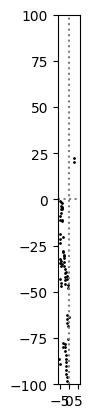

In [180]:
plt.scatter(neighbor_y.cpu(), neighbor_x.cpu(), color='black', s=1)
plt.ylim(-100, 100)
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [184]:
neighbor_indices = [ find_neighbors_batch(data, data[k], batch_size=100000000) for k in trange(len(data))  ]

100%|██████████| 1208443/1208443 [06:31<00:00, 3090.31it/s]


In [198]:
torch.save(neighbor_indices, 'D:/Productivity/Projects/RiskFieldImitation-main/data/reduced_neighbor_indices')

In [191]:
len(neighbor_indices[8874])

1283

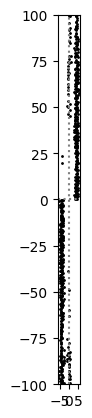

In [195]:
idx = 8874
neighbors = data[neighbor_indices[idx]]
neighbor_x = neighbors[:,8]*20
neighbor_y = neighbors[:,9]*5
plt.scatter(neighbor_y.cpu(), neighbor_x.cpu(), color='black', s=1)
plt.ylim(-100, 100)
plt.xlim(-6, 6)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

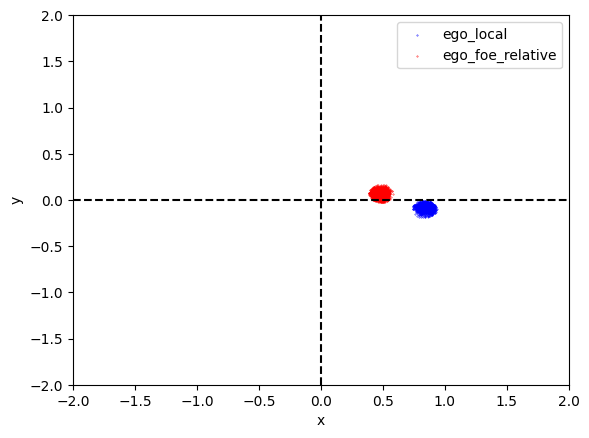

In [197]:
plt.scatter(neighbors[:,0].cpu(), neighbors[:,1].cpu(), color='blue', s=0.1, label='ego_local')
plt.scatter(neighbors[:,2].cpu(), neighbors[:,3].cpu(), color='red', s=0.1, label='ego_foe_relative')
plt.axhline(0, linestyle='dashed', color='black')
plt.axvline(0, linestyle='dashed', color='black')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [6]:

# Function to get top-k neighbors within epsilon using bins
def find_neighbors(data, grouped_data, bin_indices, batch_size=10000, epsilon=0.20, k=100, feature_dims = [0,1,2,3,4,5,6,7]):
    neighbor_dict = {}
    N = len(data)
    # Process data in batches to maximize GPU parallelism
    for i in range(0, N, batch_size):
        batch_data = data[i:i+batch_size]  # Extract batch
        batch_bins = bin_indices[i:i+batch_size]
        # Convert batch bins to tuple keys
        batch_keys = [tuple(row.tolist()) for row in batch_bins]

        # Get all potential neighbor indices from adjacent bins
        candidate_indices = []
        for key in batch_keys:
            adjacent_bins = list(itertools.product(
                *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
            ))
            for adj_bin in adjacent_bins:
                if adj_bin in grouped_data:
                    candidate_indices.extend(grouped_data[adj_bin].tolist())

        if not candidate_indices:
            continue  # Skip if no neighbors

        candidate_indices = torch.tensor(candidate_indices, device="cuda")
        candidate_data = data[candidate_indices]  # Retrieve full data

        # Compute distances in parallel for the entire batch
        distances = torch.cdist(batch_data[:,feature_dims], candidate_data[feature_dims])

        # Get top-k nearest neighbors under epsilon
        mask = distances < epsilon
        top_k_indices = torch.argsort(distances, dim=1)[:, :k]  # Sort and take top-k

        # Store results in a dictionary
        for j in trange(batch_data.shape[0]):
            valid_neighbors = candidate_indices[top_k_indices[j][mask[j, top_k_indices[j]]]]
            neighbor_dict[i + j] = valid_neighbors.tolist()

    return neighbor_dict




In [7]:
# get all indices
all_indices = find_neighbors(data, grouped_data=grouped_data, batch_size=1000000,feature_dims=feature_dims)

TypeError: find_neighbors() missing 1 required positional argument: 'bin_indices'

In [10]:
i= 5000
batch_size = 15000
batch_data = data[i:i+batch_size]
batch_bins = bin_indices[i:i+batch_size]

In [16]:
idx = 500232
key = bin_indices[idx]
# adjacent_bins = list(itertools.product(
#                 *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
#             ))
[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]


[(tensor(6, device='cuda:0', dtype=torch.int32),
  tensor(7, device='cuda:0', dtype=torch.int32),
  tensor(8, device='cuda:0', dtype=torch.int32)),
 (tensor(-2, device='cuda:0', dtype=torch.int32),
  tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32)),
 (tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32),
  tensor(2, device='cuda:0', dtype=torch.int32)),
 (tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32),
  tensor(2, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(1, device='cuda:0', dtype=torch.int32)),
 (tensor(-1, device='cuda:0', dtype=torch.int32),
  tensor(0, device='cuda:0', dtype=torch.int32),
  tensor(

In [ ]:
batch_data = data[i:i+batch_size]  # Extract batch
        batch_bins = bin_indices[i:i+batch_size]
        # Convert batch bins to tuple keys
        batch_keys = [tuple(row.tolist()) for row in batch_bins]

        # Get all potential neighbor indices from adjacent bins
        candidate_indices = []
        for key in batch_keys:
            adjacent_bins = list(itertools.product(
                *[(key[j] - 1, key[j], key[j] + 1) for j in range(len(feature_dims))]
            ))
            for adj_bin in adjacent_bins:
                if adj_bin in grouped_data:
                    candidate_indices.extend(grouped_data[adj_bin].tolist())

tensor([[ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  0,  0,  0,  0, 10],
        [ 9,  0,  6,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  0, 10],
        [ 9,  0, -2,  1,  0,  0,  0,  0],
        [ 9,  0,  6,  1,  0,  0,  0, 10],
        [ 9,  0, -7,  0,  0,  0,  